# Task 3

Begin by exploring the instructor's notebook that introduces the application of Random Fourier Features (RFF) for image reconstruction. Demonstrate the following applications using the cropped image from the notebook:

**1. Super-resolution**: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) 

**2. Quantitative comparison:** The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics: 

    - RMSE on predicted v/s ground truth high resolution image

    - Peak SNR on predicted v/s ground truth high resolution image

## Follow the below steps to execute this task:

* Start with a 400x400 high-resolution image (the original image).
* Resize it to a 200x200 image (this will be your input image). You can use OpenCV's resize function or another library for this. Here’s a tutorial to help: OpenCV Resize Image Tutorial.
* Use Random Fourier Features (RFF) along with linear regression to learn a function based on the 200x200 image.
* Use the learned function to predict the pixel values for the 400x400 image. This means predicting the values for the pixels that fall between the existing pixels of the 200x200 image.
* Compare your predicted 400x400 image with the original 400x400 high-resolution image.
* Calculate the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the predicted image and the original high-resolution image.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# # Set env CUDA_LAUNCH_BLOCKING=1
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
#rearranging the channel differnece in between matplotlib expectations and torch expectations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 662.8 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


## Accessing the image

In [3]:
import requests

response = requests.get('https://images.unsplash.com/photo-1534759846116-5799c33ce22a?q=80&w=1950&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

if response.status_code == 200:
    with open('leopard.jpg', 'wb') as f:
        f.write(response.content)
    print('leopard.jpg downloaded')
else:
    print('Failed to download image')

leopard.jpg downloaded


In [4]:
#Read in a image from torchvision
img = torchvision.io.read_image("leopard.jpg")
print(img.shape)

torch.Size([3, 2517, 1950])


(2517, 1950, 3)

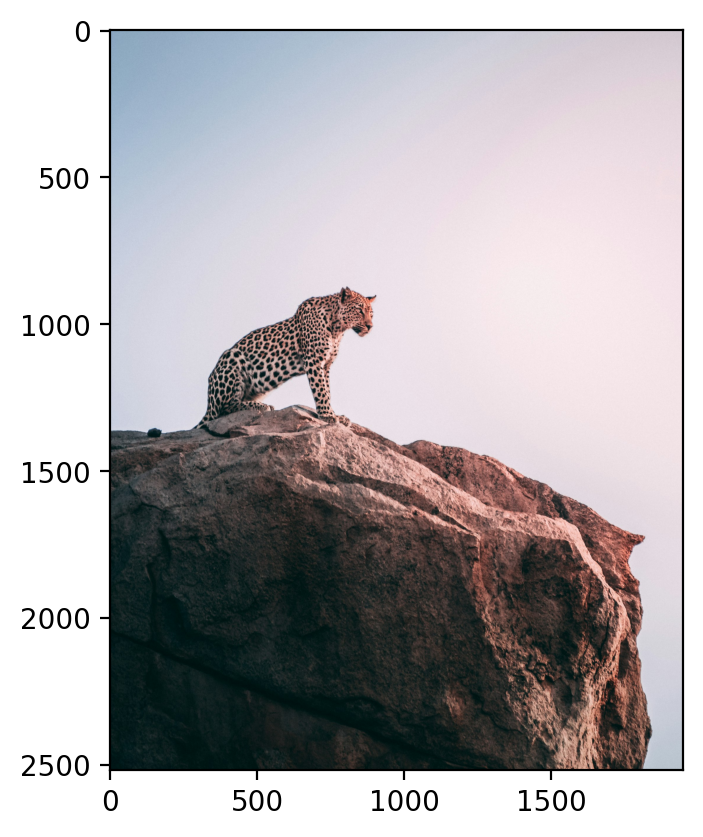

In [5]:
'''
The rearrangement is done to convert the image from the default CHW (Channel-Height-Width) order to HWC (Height-Width-Channel) order,
which is the typical order used in image processing and display.

we convert to np because that is what matplotlib expects.

'''
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
rearrange(img, 'c h w -> h w c').numpy().shape

In [6]:
from sklearn import preprocessing

In [7]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

def pre_process_img(img, scaler_img):
  img_array = np.array(img)
  img_scaled = scaler_img.transform(img_array.reshape(-1, 1)).reshape(img_array.shape)
  print(f"The scaled image shape (scaled in np form) : {img_scaled.shape}")

  img_scaled = torch.tensor(img_scaled).float()

  plt.imshow(rearrange(img_scaled, 'c h w -> h w c').numpy())

  return img_scaled

The scaled image shape (scaled in np form) : (3, 2517, 1950)


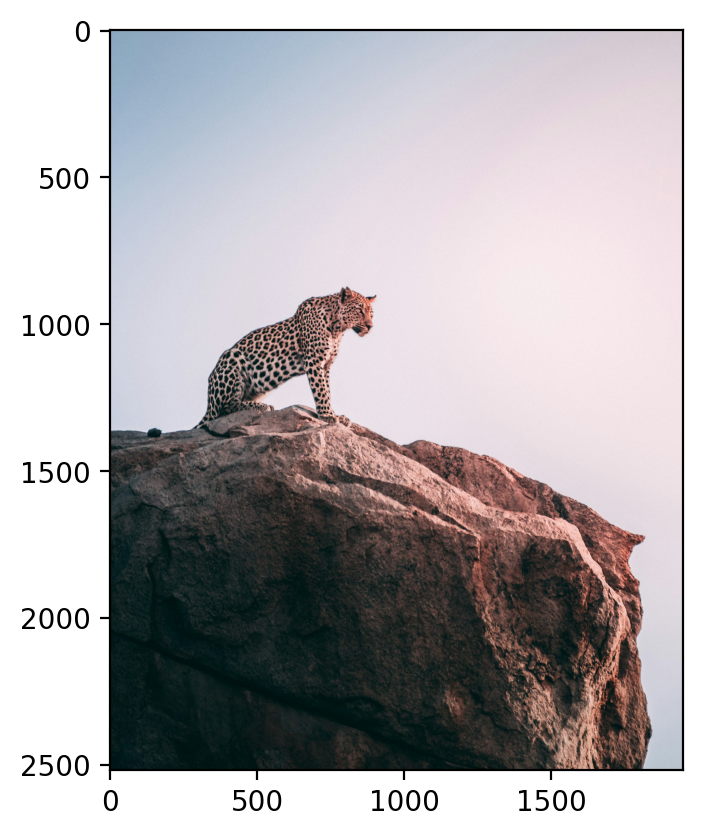

In [8]:
img_scaled = pre_process_img(img, scaler_img)
img_scaled = img_scaled.to(device)

## 400 * 400 High Resolution image cropping

In [9]:
import torchvision.utils as utils

In [10]:
#here we manually need to put the values. 
#torchvision.transforms.functional.crop(img: Tensor, top: int, left: int, height: int, width: int) → Tensor
# top => vertical component of top left, left => hz. componenet of it. 
crop = torchvision.transforms.functional.crop(img_scaled.to(device), 850, 510, 400, 400) #we can get the required by trial and error. 
crop = crop.to(device)
utils.save_image(crop, '/kaggle/working/leopard_cropped.jpg')
crop.shape

torch.Size([3, 400, 400])

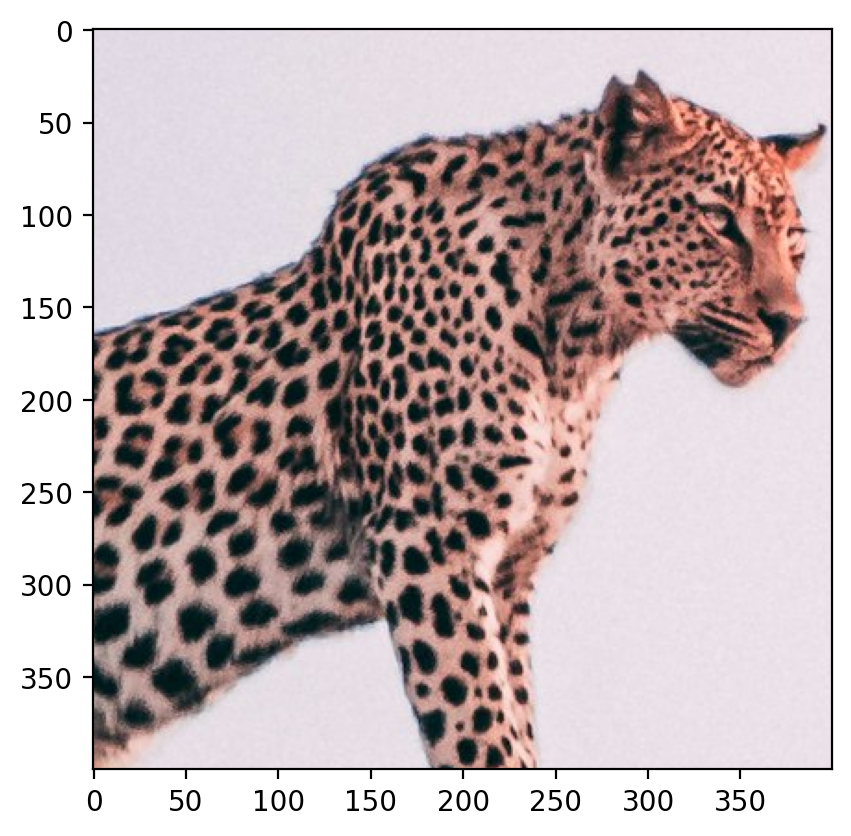

In [11]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

## Resizing with Cv2

In [12]:
import cv2

Original Dimensions :  (400, 400, 3)
Resized Dimensions :  (200, 200, 3)
Resized image saved as /kaggle/working/leopard_cropped_resized.jpg


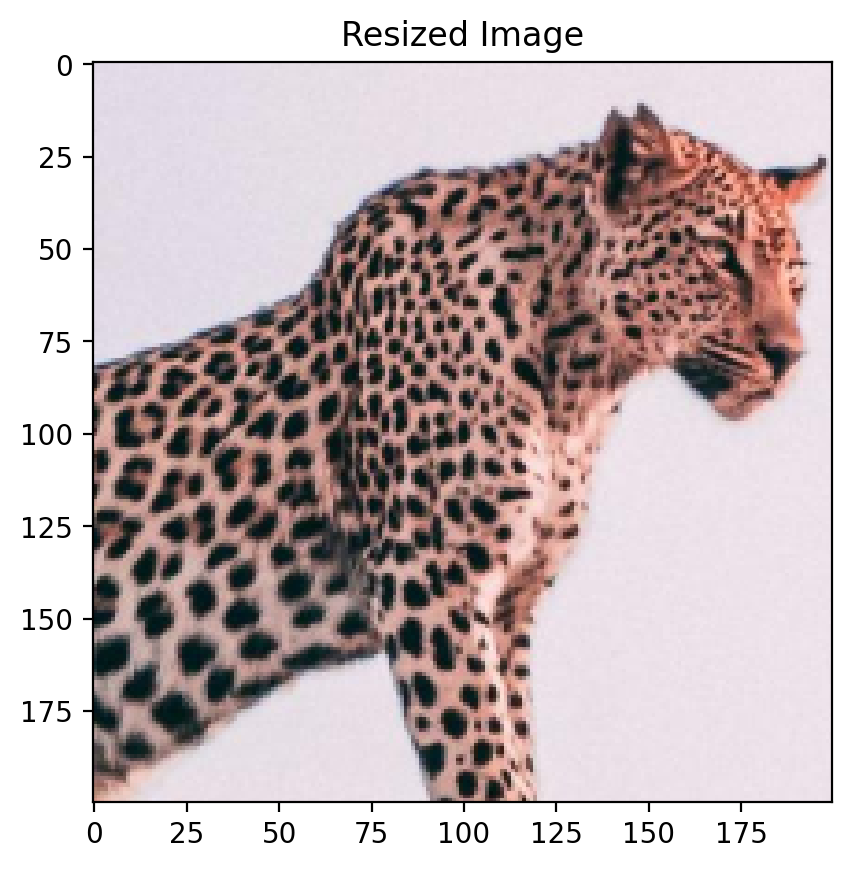

In [13]:
img_og = cv2.imread('/kaggle/working/leopard_cropped.jpg', cv2.IMREAD_UNCHANGED)

print('Original Dimensions : ', img_og.shape)

width = 200
height = 200
dim = (width, height)

resized = cv2.resize(img_og, dim, interpolation=cv2.INTER_AREA)

print('Resized Dimensions : ', resized.shape)

output_path = '/kaggle/working/leopard_cropped_resized.jpg'
cv2.imwrite(output_path, resized)
print(f'Resized image saved as {output_path}')

resized_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

plt.imshow(resized_rgb)
plt.axis('on') 
plt.title("Resized Image")
plt.show()

## Displaying both images 

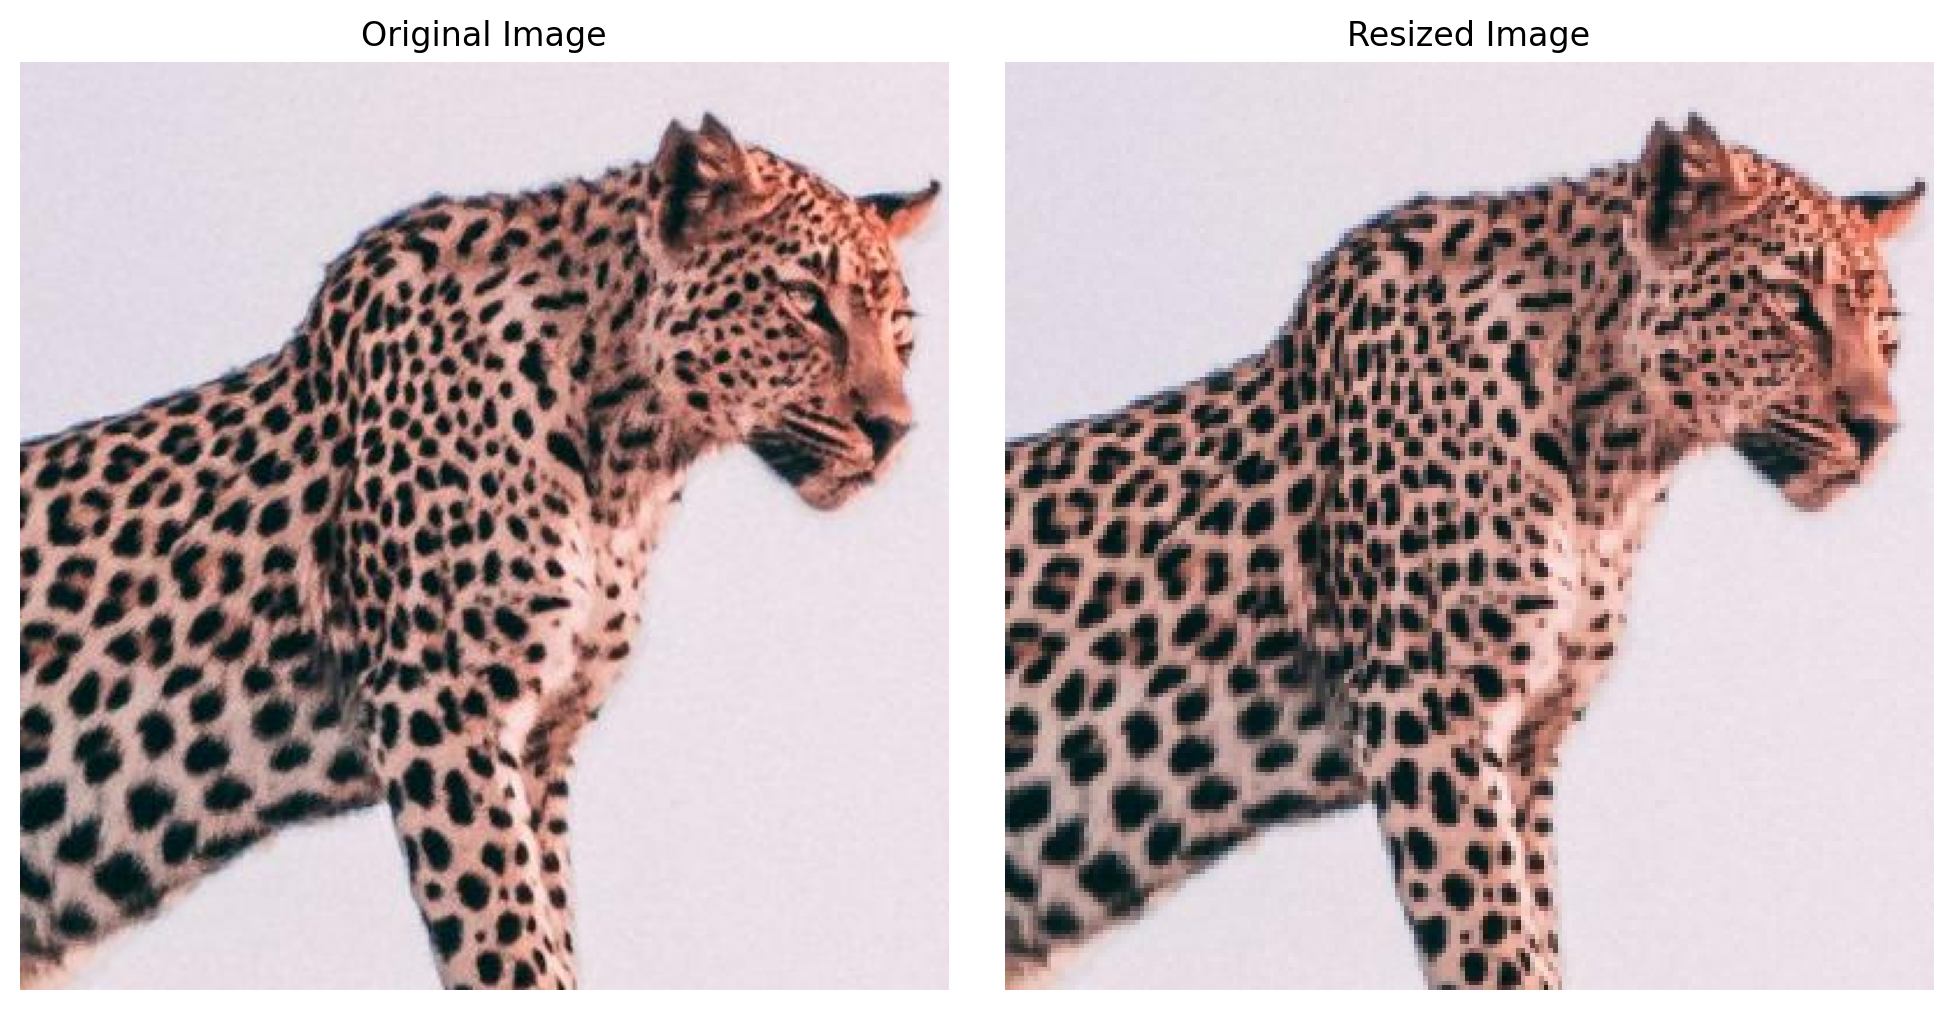

In [14]:
img_og_rgb = cv2.cvtColor(img_og, cv2.COLOR_BGR2RGB)
resized_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))  

plt.subplot(1, 2, 1) 
plt.imshow(img_og_rgb)
plt.title('Original Image')
plt.axis('off')  


plt.subplot(1, 2, 2)
plt.imshow(resized_rgb)
plt.title('Resized Image')
plt.axis('off')  

plt.tight_layout()
plt.show()

## Preprocessing for function learning 

In [15]:
tensor_img = torch.tensor(resized_rgb / 255.0, dtype=torch.float32)

#Permute the dimensions from (Height, Width, Channels) -> (Channels, Height, Width)
tensor_img = tensor_img.permute(2, 0, 1)

#Verify the shape is now (3, 200, 200)
print(tensor_img.shape)

torch.Size([3, 200, 200])


### verification

In [16]:
# #checking my image
# plt.imshow(resized_rgb)
# plt.title('Resized RGB Image (NumPy Array)')
# plt.show()

# # Visualize the tensor_img by rearranging it back to (Height, Width, Channels)
# # Also, convert back to NumPy and ensure it's in the range [0, 1] for display
# plt.imshow(rearrange(tensor_img, 'c h w -> h w c').cpu().numpy())
# plt.title('Tensor Image (Converted from NumPy)')
# plt.show()

In [17]:
num_channels, height, width = tensor_img.shape
print(f"The number of channels: {num_channels}, The height of the image {height}px, The width of the image: {width}px")

The number of channels: 3, The height of the image 200px, The width of the image: 200px


In [18]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)

    We are transforming the image in 2 tensors => pixel coordinates and pixel values(features)

    
    """

    num_channels, height, width = img.shape

    #Create a 2D grid of (x,y) coordinates (h, w)
    #width values change faster than height values
    
    w_coords = torch.arange(width).repeat(height, 1) #2d grid, with x coordinates varying across columns.
    h_coords = torch.arange(height).repeat(width, 1).t() #2d grid, with y coordinates varying across rows. 
    
    #making both into a 1D tensor
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    #Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float() # [y,x]....

    X = X.to(device)

    #Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [19]:
leopard_X, leopard_Y = create_coordinate_map(tensor_img)

print(f"The shape of my coordinate tensor : {leopard_X.shape}, \nThe shape of my pixel tensor : {leopard_Y.shape}")

The shape of my coordinate tensor : torch.Size([40000, 2]), 
The shape of my pixel tensor : torch.Size([40000, 3])


In [20]:
print(leopard_X[:5])
#notice how we have scaled even rgb for numerical stability. 
'''
Raw RGB values in the range of 0 to 255 can cause issues like vanishing or exploding gradients, especially in deeper networks. 
Scaling the RGB values helps prevent these issues by keeping the input values within a range that makes training more stable and efficient.

'''
print("\n")
print(leopard_Y[:5])

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.]], device='cuda:0')


tensor([[0.8824, 0.8510, 0.9020],
        [0.8863, 0.8549, 0.9059],
        [0.8863, 0.8549, 0.9059],
        [0.8824, 0.8510, 0.9020],
        [0.8863, 0.8549, 0.9059]])


In [21]:
#Here, we scaled the x-coordinates 

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(leopard_X.cpu())

# Scale the X coordinates
leopard_X_scaled = scaler_X.transform(leopard_X.cpu())

# Move the scaled X coordinates to the GPU
leopard_X_scaled = torch.tensor(leopard_X_scaled).to(device)

# Set to dtype float32
leopard_X_scaled = leopard_X_scaled.float()

## Defining RMSE and PSNR 

In [22]:
import torch
import torch.nn.functional as F

In [23]:

def rmse_psnr(original_img, reconstructed_img):
    """
    Computes the RMSE and PSNR between the original and reconstructed images.
    
    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_img: torch.Tensor of the same shape as original_img or (height, width, num_channels)
    """
    original_img = original_img.float()
    reconstructed_img = reconstructed_img.float()
    
    if original_img.shape != reconstructed_img.shape:
        raise ValueError(f"Shape mismatch: original_img {original_img.shape} vs reconstructed_img {reconstructed_img.shape}")

    # Compute RMSE
    mse = F.mse_loss(reconstructed_img, original_img)
    rmse = torch.sqrt(mse).item()

#     # Compute PSNR
#     max_pixel_value = 1.0  # Assume images are normalized to [0, 1]
#     psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse)).item()
    
    max_pixel = 255.0  #now our max is 255 because we resized again
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    
    return (rmse, psnr)


## Learning the 200 * 200 image with RFF

In [24]:
from sklearn.kernel_approximation import RBFSampler

In [52]:
def create_rff_features(X, num_features, sigma):
    
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=10)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [26]:
num_features_rff = 15000

In [27]:
torch.cuda.empty_cache()

In [28]:
X_rff = create_rff_features(leopard_X_scaled, num_features_rff, 0.008)
X_rff = X_rff.to(device)

In [29]:
X_rff.shape

torch.Size([40000, 15000])

In [30]:
class LinearModel(nn.Module):
  #subclass of the torch.nn.module 
    def __init__(self, in_features, out_features):
      #constructor 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features) #Y = XW+b

    def forward(self, x):
        return self.linear(x)

In [31]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [32]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2) in our case, only 1 sample. 
    Y: torch.Tensor of shape (num_samples, 3)
    verbose = true prints loss every 100 epochs 
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()

        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return f"the final loss is {loss.item()}"

In [33]:
leopard_Y=leopard_Y.to(device)

In [34]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, leopard_Y, 1000)

Epoch 0 loss: 0.505283
Epoch 100 loss: 0.097525
Epoch 200 loss: 0.040166
Epoch 300 loss: 0.030779
Epoch 400 loss: 0.025112
Epoch 500 loss: 0.020728
Epoch 600 loss: 0.017270
Epoch 700 loss: 0.014521
Epoch 800 loss: 0.012323
Epoch 900 loss: 0.010556


'the final loss is 0.009140615351498127'

In [35]:
leopard_X_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]], device='cuda:0')

In [36]:
og_tensor_img = torch.tensor(img_og_rgb, dtype=torch.float32)

#PyTorch expects images in [Channels, Height, Width] format
og_tensor_img = og_tensor_img.permute(2, 0, 1)

# Verify the shape is now (3, 200, 200)
print(og_tensor_img.shape)

torch.Size([3, 400, 400])


In [37]:
leopard_Y.shape

torch.Size([40000, 3])

In [38]:
leopard_X_og, leopard_Y_og = create_coordinate_map(og_tensor_img)

In [39]:
#Here, we scaled the x-coordinates 

#MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(leopard_X_og.cpu())

#Scale the X coordinates
leopard_X_scaled_og = scaler_X.transform(leopard_X_og.cpu())

#Move the scaled X coordinates to the GPU
leopard_X_scaled_og = torch.tensor(leopard_X_scaled_og).to(device)

#Set to dtype float32
leopard_X_scaled_og = leopard_X_scaled_og.float()

# with torch.no_grad():  # Disable gradient computation for inference
#     predictions = net(leopard_X_scaled_og)  # Assuming the model is already trained

leopard_X_scaled_og.shape

torch.Size([160000, 2])

In [40]:
torch.cuda.empty_cache()

In [41]:
def normalize_to_rgb(img):
    # Find the minimum and maximum values of the image
    min_val = img.min()
    max_val = img.max()
    
    #Normalize the image to the range [0, 255]
    img_normalized = (img - min_val) / (max_val - min_val) * 255
    
    #Clip values to ensure they are in the range [0, 255]
    img_normalized = torch.clamp(img_normalized, 0, 255)
    
    #Convert to integer type (uint8) since RGB images need to be integers
    img_normalized = img_normalized.to(torch.uint8)
    
    return img_normalized


## Predicting 200*200 image based on our learnt model

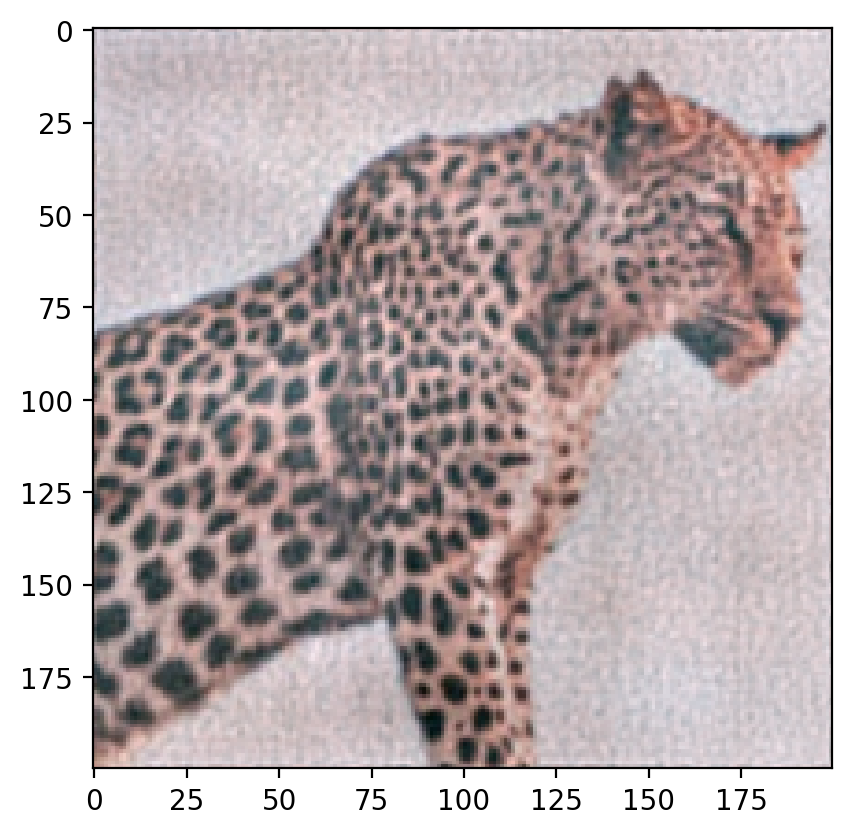

In [42]:
num_channels, height, width = tensor_img.shape
net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(height, width, num_channels)
    #outputs = outputs.permute(1, 2, 0)

recon_200 =  normalize_to_rgb(outputs.cpu())
plt.imshow(recon_200)

In [43]:
tensor_img_scaled=normalize_to_rgb(tensor_img)
recon_200_scaled = normalize_to_rgb(recon_200)

## Compressed Image PSNR and RMSE comparison

In [44]:
rmse,psnr=rmse_psnr(torch.reshape(tensor_img_scaled, (200,200,3)), recon_200_scaled )
print(f"\nThe rmse of the image is {rmse}\nThe PSNR of the image is {psnr}")


The rmse of the image is 83.56769561767578
The PSNR of the image is 9.690035820007324


In [45]:
def show_images_side_by_side(img1, img2,title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    #img1 is already in (H, W, C) format, no need to permute
    img1 = img1.numpy()
    
    #img2 is in (C, H, W), so permute to (H, W, C)
    img2 = img2.permute(1, 2, 0).numpy()  # Change to (400, 400, 3)
    
    #Display the first image
    axs[0].imshow(img1)
#     axs[0].set_xlabel('Image 1 X-axis Label')  # You can fill in
#     axs[0].set_ylabel('Image 1 Y-axis Label')  # You can fill in
    axs[0].set_title('Reconstructed')  # You can fill in
    
    # Display the second image
    axs[1].imshow(img2)
#     axs[1].set_xlabel('Image 2 X-axis Label')  # You can fill in
#     axs[1].set_ylabel('Image 2 Y-axis Label')  # You can fill in
    axs[1].set_title('Original')  # You can fill in
    
    # Add an overall title for both images
    fig.suptitle(title)  # You can fill in
    
    plt.show()

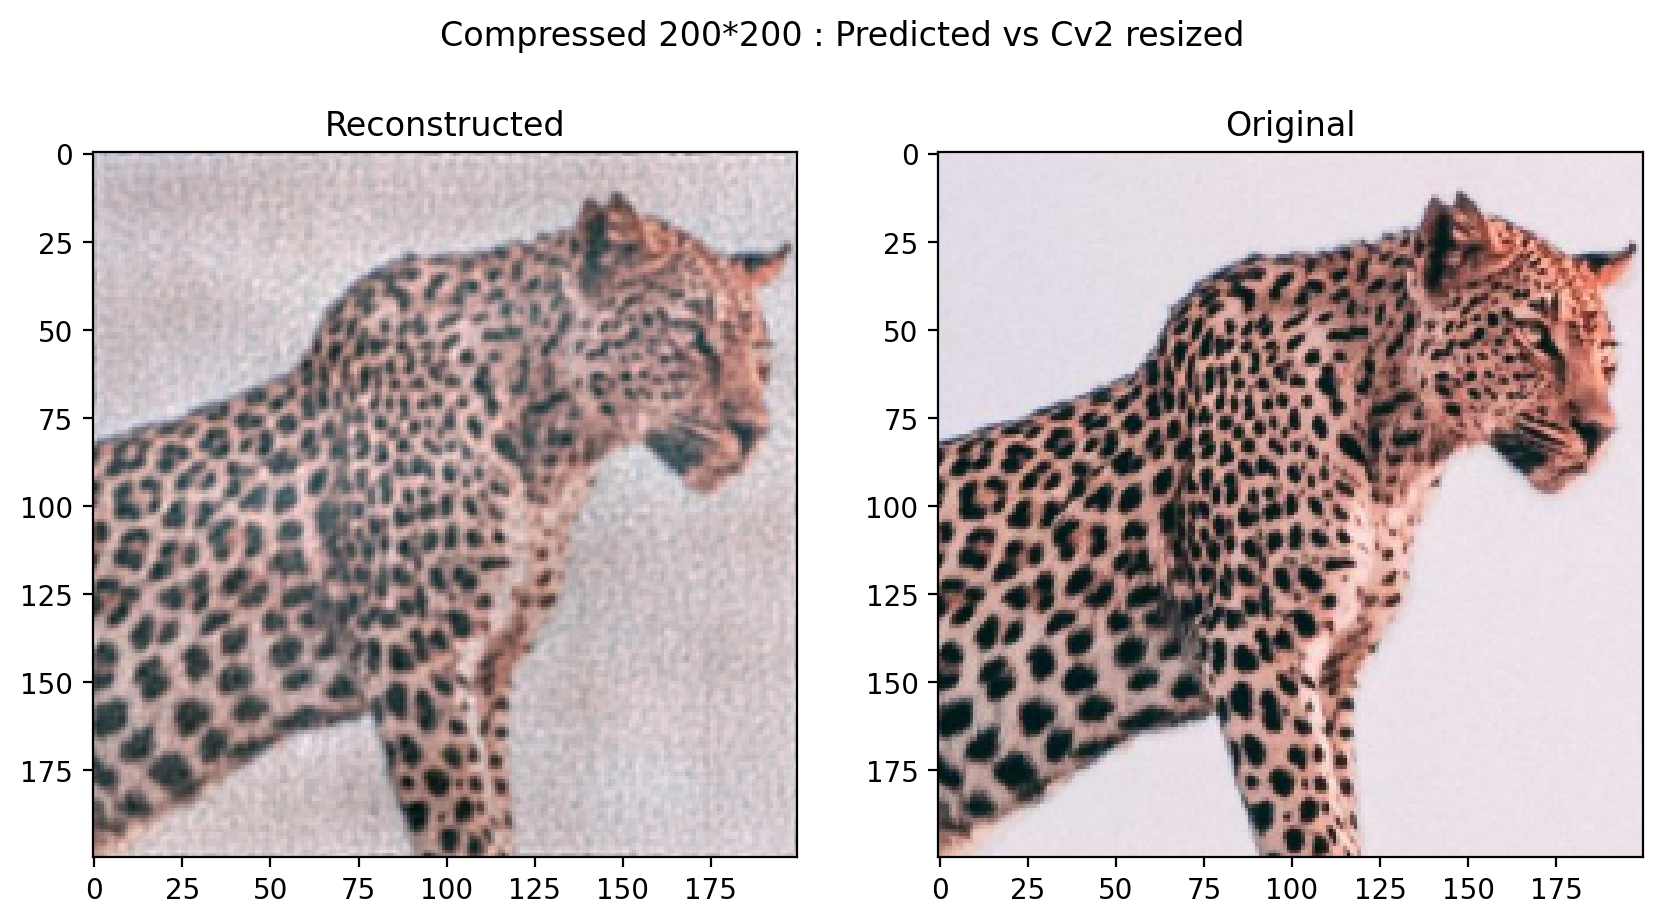

In [46]:
show_images_side_by_side(recon_200_scaled, tensor_img, "Compressed 200*200 : Predicted vs Cv2 resized")

## Creating features of the 400 * 400 image for prediction

In [47]:
X_rff_og = create_rff_features(leopard_X_scaled_og, num_features_rff, 0.008)

## Single forward pass for 400*400

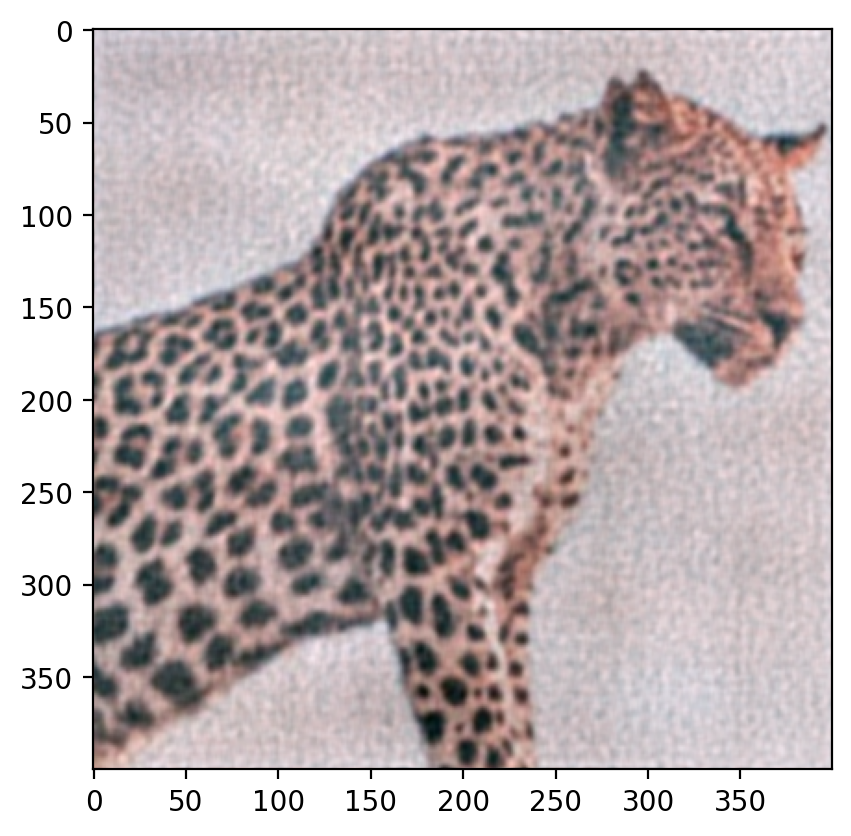

In [48]:
num_channels, height, width = og_tensor_img.shape
net.eval()
with torch.no_grad():
    outputs = net(X_rff_og)
    outputs = outputs.reshape(height, width, num_channels)
    #outputs = outputs.permute(1, 2, 0)

recon_400 =  normalize_to_rgb(outputs.cpu())
plt.imshow(recon_400)

## Super resolution -> Predicting

In [49]:
crop_alt = crop.cpu()
crop_alt_scaled=normalize_to_rgb(crop_alt)

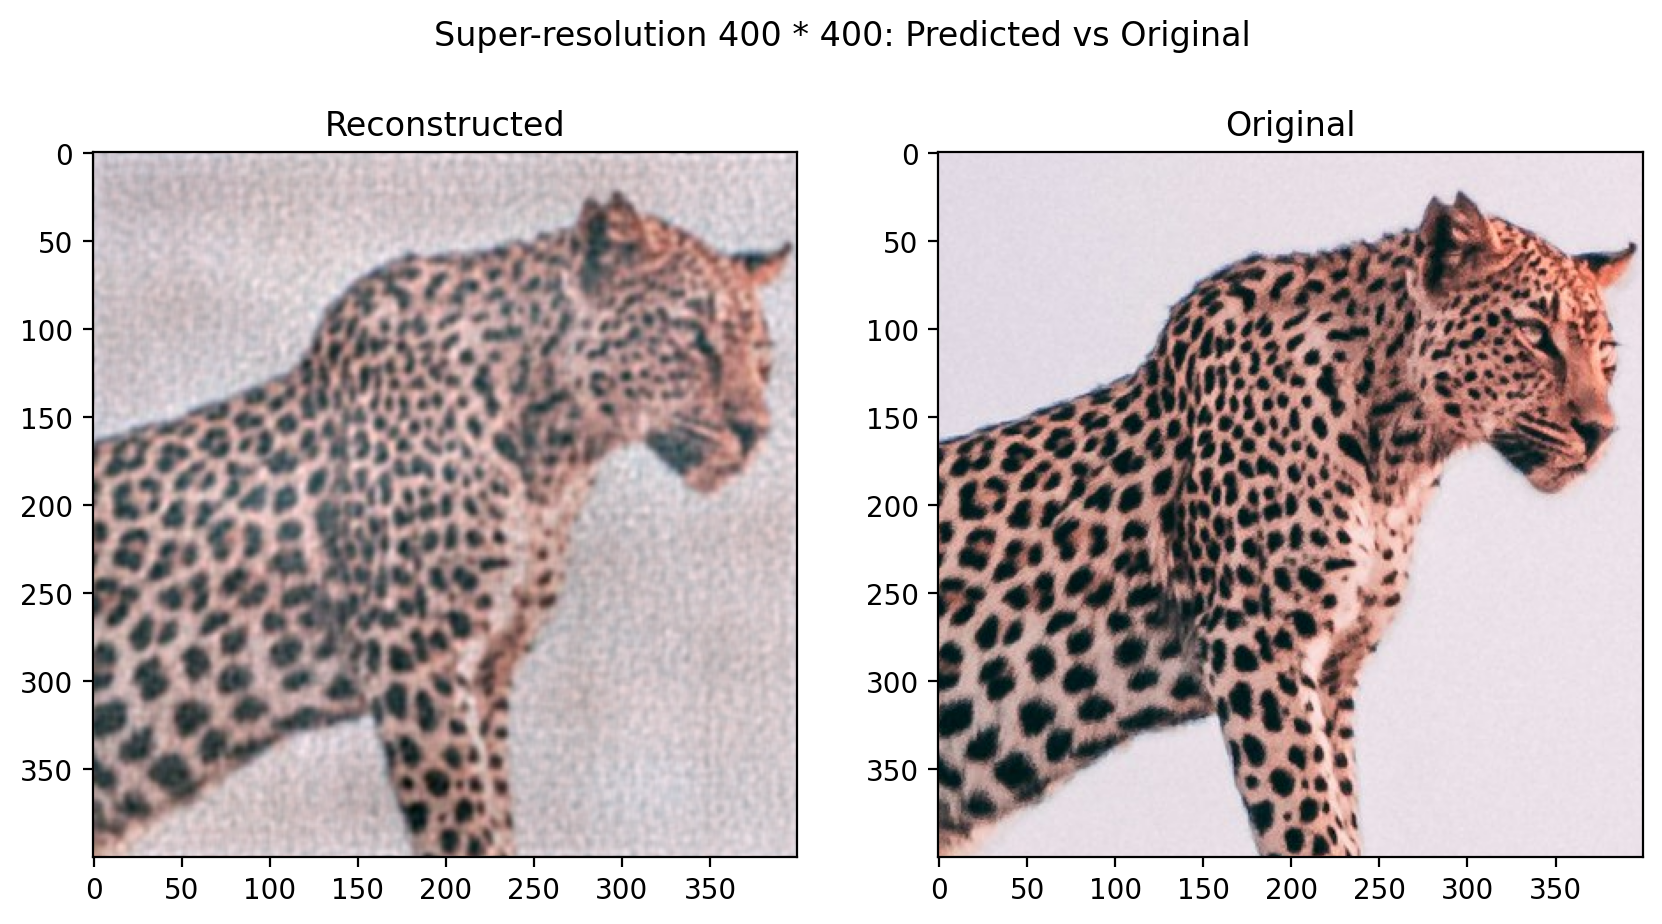

In [50]:
show_images_side_by_side(recon_400, crop_alt_scaled, "Super-resolution 400 * 400: Predicted vs Original")

## Super-resolution rmse and psnr

In [51]:
rmse,psnr=rmse_psnr(torch.reshape(crop_alt_scaled, (400,400,3)), recon_400) 
print(f"The rmse of the image is {rmse}\nThe PSNR of the image is {psnr}")

The rmse of the image is 84.31893920898438
The PSNR of the image is 9.612300872802734
